In [9]:
import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = 'data\seg_train\seg_train'
test_dir = 'data\seg_test\seg_test'
pred_dir = 'data\seg_pred\seg_pred'

**Explore the data**

In [3]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")
for dirpath, dirnames, filenames in os.walk(pred_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

There are 6 directories and 0 files in data\seg_train\seg_train
There are 0 directories and 2191 files in data\seg_train\seg_train\buildings
There are 0 directories and 2271 files in data\seg_train\seg_train\forest
There are 0 directories and 2404 files in data\seg_train\seg_train\glacier
There are 0 directories and 2512 files in data\seg_train\seg_train\mountain
There are 0 directories and 2274 files in data\seg_train\seg_train\sea
There are 0 directories and 2382 files in data\seg_train\seg_train\street
There are 6 directories and 0 files in data\seg_test\seg_test
There are 0 directories and 437 files in data\seg_test\seg_test\buildings
There are 0 directories and 474 files in data\seg_test\seg_test\forest
There are 0 directories and 553 files in data\seg_test\seg_test\glacier
There are 0 directories and 525 files in data\seg_test\seg_test\mountain
There are 0 directories and 510 files in data\seg_test\seg_test\sea
There are 0 directories and 501 files in data\seg_test\seg_test\stree

In [4]:
image_categories = os.listdir(train_dir)
print(image_categories)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [6]:
def random_image(directory_path, category_name = 'random'):
    count = 0
    chosen_file = None 
    categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    if category_name == 'random':
        category_name = random.choice(categories)

    folder_path = os.path.join(directory_path, category_name)

    with os.scandir(folder_path) as images:
        for image in images:
            count += 1
            if random.randint(1, count) ==1:
                chosen_file = image.name
     
    image_path = os.path.join(folder_path, chosen_file)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(image_path)

    print(f"Image shape: {image.shape}")
    return image

Image shape: (150, 150, 3)


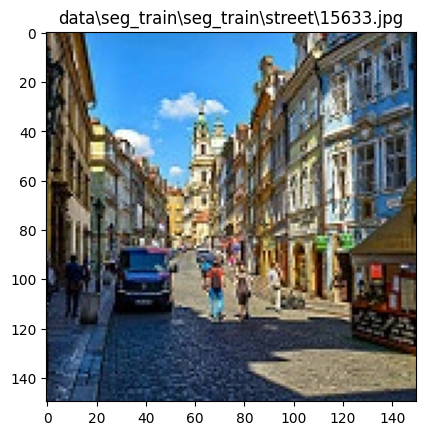

In [7]:
img = random_image(train_dir)

In [31]:
# Creates an ImageDataGenerator object to augment the training data
generate_train_data = ImageDataGenerator(rotation_range=0,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            brightness_range=(0.7, 1.3),
                            shear_range=0.2,
                            zoom_range=0.2,
                            rescale = 1/255, 
                            horizontal_flip=True,
                            vertical_flip=False)

# Returns an iterator with batches of 32 images
train_data = generate_train_data.flow_from_directory(
                                    train_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=32,
                                    shuffle=True,
                                    # save_to_dir=None,
                                    # save_prefix='',
                                    # save_format='png',
                                    subset='training')

Found 14034 images belonging to 6 classes.


**View the structure of the augmented train data**

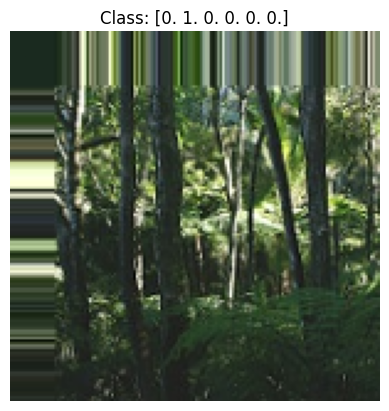

In [28]:
# Train_data is an iterator, so we fetch the first set of items
image_batch, label_batch = next(train_data)
image = image_batch[0]
label = label_batch[0]

plt.imshow(image)
plt.title('Class: {}'.format(label))  # Labels are one hot encoded between the 6 categories
plt.axis('off')
plt.show()

In [33]:
# Repeat the process for test data
generate_test_data = ImageDataGenerator(
                                rescale=1/255)

test_data = generate_test_data.flow_from_directory(
                                    test_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=32,
                                    shuffle=True)
                                    # save_to_dir=None,
                                    # save_prefix='',
                                    # save_format='png',

Found 3000 images belonging to 6 classes.


**Creating the CNN Architecture**